# Exercise 6: Hopfield Network

**Note**: Please insert the names of all participating students:
1. 
2. 
3. 

In this exercise, we will train a Hopfield network to recognize handwritten digits. A Hopfield network is a neural network with feedback, i.e. the `activations` of the network at time $t$ becomes the input of the network at time $t + 1$. The `activation` of neuron $j$ at time $t+1$ is given by

$$
\begin{equation}
    y_j \left( t+1 \right) = 
        \left\{ 
            \begin{array}{rl}
                1, & \text{if } \sum_{i=1}^{N} w_{ij} y_{i}\left( t \right) \geq \theta \\
                -1, & \text{else}
            \end{array} 
        \right.
\end{equation}
$$

where $N$ is the number of neurons in the Hopfield network and $w_{ij}$ is the `weight` between neuron $i$ and $j$.

If the `weights` are initialized suitably, the Hopfield network can be used as an autoassociative memory that recognizes a certain number of patterns. When presented with an initial input, the network will converge to the learned pattern that most closely resembles that input.

To achieve this, the weights need to be initialized as follows:

$$
\begin{equation}
    w_{ij} = 
        \left\{ 
            \begin{array}{rl}
                0, & \text{if } i = j \\
                \frac{1}{N}\sum_{\mu = 1}^{p} x_{i}^{\mu} x_{j}^{\mu}, & \text{else}
            \end{array} 
        \right.
\end{equation}
$$

where $\boldsymbol{x}^{\mu}$ ($\mu = 1, . . . , p$) are the `patterns` to be learned, $N$ is the total number of neurons and $x_i^{\mu}$ is the $i$-th
component of pattern $\boldsymbol{x}^{\mu}$.

## Preamble
The following code downloads and imports all necessary files and modules into the virtual machine of Colab. Please make sure to execute it before solving this exercise. This mandatory preamble will be found on all exercise sheets.

In [6]:
import sys, os
!wget -nc https://raw.githubusercontent.com/inb-uni-luebeck/cs4405/master/utils/utils_6.py
!wget -nc https://github.com/inb-uni-luebeck/cs4405/raw/master/data/data_6.npz

import numpy as np
from matplotlib import pyplot as plt
import utils_6 as utils

File ‘utils_6.py’ already there; not retrieving.

--2023-06-06 08:01:39--  https://github.com/inb-uni-luebeck/cs4405/raw/master/data/data_6.npz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/inb-uni-luebeck/cs4405/master/data/data_6.npz [following]
--2023-06-06 08:01:39--  https://raw.githubusercontent.com/inb-uni-luebeck/cs4405/master/data/data_6.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5390 (5.3K) [application/octet-stream]
Saving to: ‘data_6.npz’

data_6.npz          100%[===================>]   5.26K  --.-KB/s    in 0s      

2023-06-06 08:01:39 (66.7 MB/s) - ‘data_6.npz’ sav

## Exercise 6.1: Weight Initialization of a Hopfield Network

**Tasks**:
- Implement the initialization of all `weights` $w_{ij}$ in the function `initialize_weights`. 
- This initialization stores the given `patterns` into the `weights`.

**Programming Hints**:
- How many neurons does the Hopfield network have based on the given `patterns`?
- How many `weights` does the fully interconnected Hopfield network have?
- Use `x.flatten()` to convert a tensor `x` to a vector.
- Use `np.outer` to computer the outer product of two vectors.
- Use `np.fill_diagonal` (note: in-place operation) to fill the diagonal of a given array.

In [3]:
def initialize_weights(patterns):
  
  # n_rows: number of rows / n_cols: number of columns of each pattern
  n_rows = patterns.shape[1]
  n_cols = patterns.shape[2]
    
  # number of neurons of the hopfield net
  n_neurons = n_rows*n_cols
    
  # initialize all weights of the hopfield net with zero
  weights = np.zeros([n_neurons, n_neurons])

  for pattern in patterns:
    
    # convert the pattern to a vector
    pattern = np.outer(pattern.flatten(), pattern.flatten())

    # update all weights (including diagonal) for the given pattern
    weights = weights+pattern

  # scale weights by the number of neurons
  weights = weights/n_neurons

  # reset diagonal elements to zero
  mask = 1-np.eye(n_neurons)
  weights *= mask
                
  return weights

## Exercise 6.2: Association of a Hopfield Network

**Tasks**:
- Implement the update rule in the function `associate`. 
- In each epoch, update the `activation` of each neuron one after the other in a random sequence (so called asynchronous update). 
- Continue updating until the net has converged, i.e. until no neuron changes its `activation`. 
- Use $\theta = 0$ as a `threshold`.

**Programming Hints**:
- What is the relation between `patterns`, `activations`, and number of neurons?
- Use `x.flatten()` to convert a tensor `x` to a vector.
- Try to avoid for-loops.

In [4]:
def associate(activations, weights, threshold=0.0):
  
  # Store the original shape
  shape = activations.shape

  # convert the activations to a vector
  activations = activations.flatten()

  # number of neurons of the hopfield net
  n_neurons = len(activations)

  # generate randomly permuted index array
  indexes = np.random.permutation(n_neurons)

  # loop until no change occurs
  while True:

    # copy activations
    copy = activations.copy()

    # iterate through all indexes in the index array
    for index in indexes:
      
      # compute the activation of neuron_index at time t+1
      activation = activations@weights[index]

      # update the activation of neuron_index
      if activation >= threshold:
        activations[index] = 1
      else:
        activations[index] = -1

    # compare copied with new activations
    if np.all(activations == copy):
      break

  return np.reshape(activations, shape)

## Exercise 6.3: Testing a Hopfield Network
**Tasks**:
- Test the Hopfield network on the handwritten digits from 0 to 9.
- First, check if the network is able to learn and distinguish all ten digits in their original form, i.e. set the `noise` to zero.
- Second, test how `noise` affects the ability of the network to recognize the digits. Experiment with different values of `noise` $\in [0,1]$. 

**Questions**:
- What is the largest subset that the network can distinguish (`noise=0.0`)?
- What is the maximum amount of noise the network can tolerate for the found subset?

**Answers**:
- 


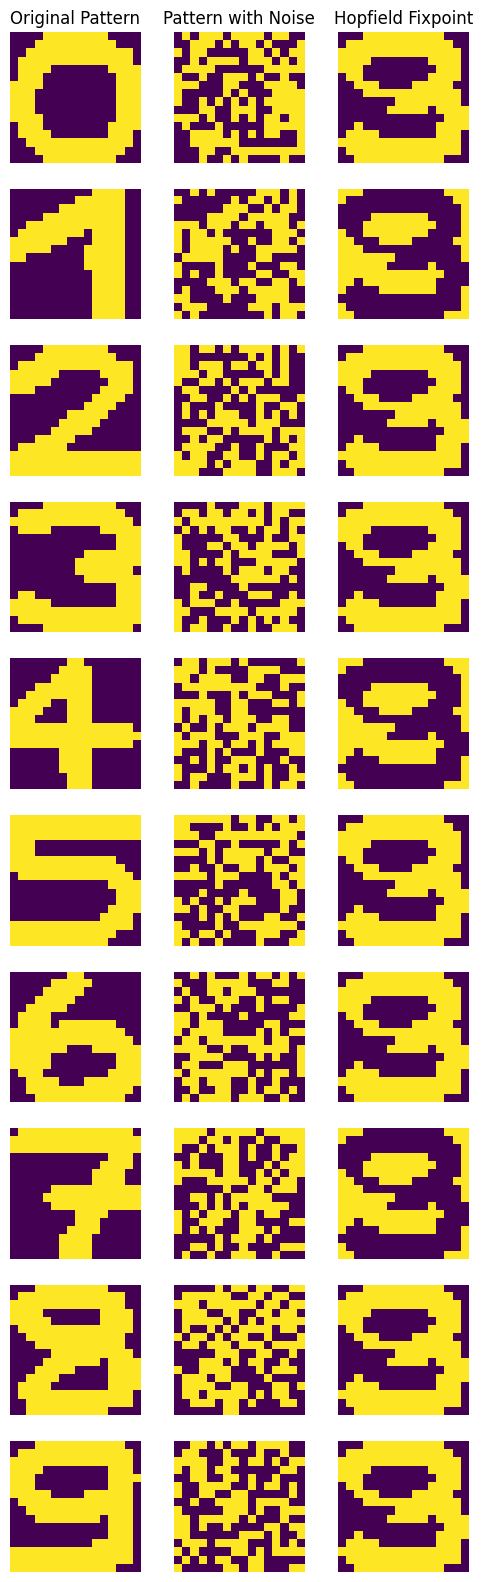

In [20]:
patterns = utils.load_data('data_6.npz')

patterns_subset = patterns[[0,1,2,3,4,5,6,7,8,9]]

weights = initialize_weights(patterns_subset)

patterns_noise = utils.add_noise(patterns_subset, noise=0.4)
#patterns_noise[:,:10] = 0

patterns_fixpoint = np.stack([associate(p, weights) for p in patterns_noise])
utils.plot(patterns_subset, patterns_noise, patterns_fixpoint)

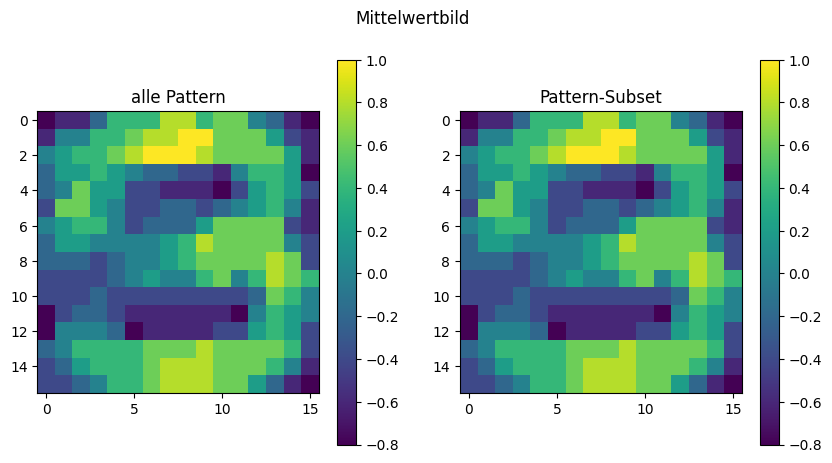

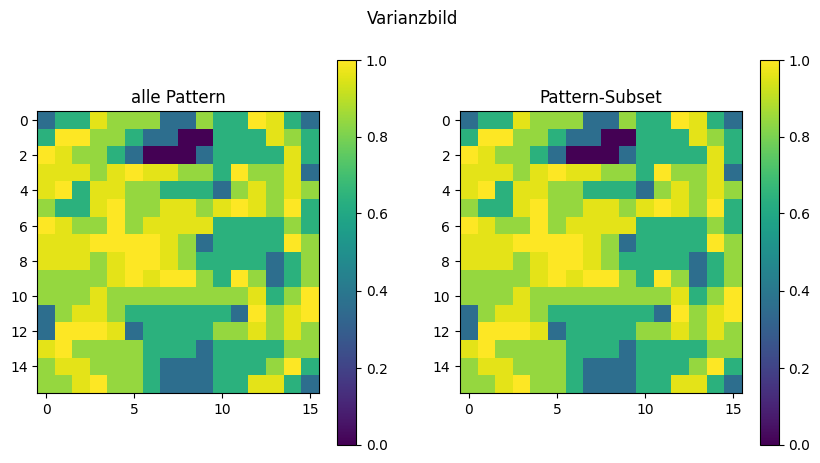

In [21]:
plt.figure(figsize=[10,5])
plt.suptitle("Mittelwertbild")
plt.subplot(1,2,1)
plt.imshow(np.mean(patterns, axis=0))
plt.title("alle Pattern")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.mean(patterns_subset, axis=0))
plt.title("Pattern-Subset")
plt.colorbar()
plt.show()

plt.figure(figsize=[10,5])
plt.suptitle("Varianzbild")
plt.subplot(1,2,1)
plt.imshow(np.var(patterns, axis=0))
plt.title("alle Pattern")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.var(patterns_subset, axis=0))
plt.title("Pattern-Subset")
plt.colorbar()
plt.show()